In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
import xarray
from aacgmv2 import convert_mlt
import seaborn as sns
from davitpy import utils
from imagers.ssusi import ssusi_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
eventDate = datetime.datetime(2011,7,5)#datetime.datetime(2011,5,16)
timeStart = datetime.datetime(2011,7,5,3)#datetime.datetime(2011,5,16,8,0)
selDate = datetime.datetime(2011,7,5,5)#datetime.datetime(2011,5,16,8,20)
timeEnd = datetime.datetime(2011,7,5,7)#datetime.datetime(2011,5,16,9,0)
azimCutoff = 30.
plotMlatRange = [ 55., 70. ]
velScale = [ 0., 1000. ]
saisVelCutoff = 50.
# Plotting SAPS vels arrows
arrowLenFactor = 8
coords = "mlt"

In [3]:
def round2(number):
    """
    Round a number to the closest half integer.
    """
    return round(number * 2) / 2

def get_west_vel(row):
    westVel = row['vLos']/( numpy.cos(\
                 numpy.deg2rad( 90.-\
                    row['azimCalcMag'] ) ) )
    if westVel >= 2000.:
        return numpy.nan
    return westVel


def convert_to_datetime(row):
    currDateStr = str( int( row["dateStr"] ) )
#     return currDateStr
    if row["timeStr"] < 10:
        currTimeStr = "000" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 100:
        currTimeStr = "00" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 1000:
        currTimeStr = "0" + str( int( row["timeStr"] ) )
    else:
        currTimeStr = str( int( row["timeStr"] ) )
    return datetime.datetime.strptime( currDateStr\
                    + ":" + currTimeStr, "%Y%m%d:%H%M" )


def get_mlon_from_mlt(row):
    if row["normMlt"] < 0: 
        currMLT = row["normMlt"] + 24.
    else:
        currMLT = row["normMlt"]
    if row["endPtnormMlt"] < 0: 
        currEndptMLT = row["endPtnormMlt"] + 24.
    else:
        currEndptMLT = row["endPtnormMlt"]
    row["Mlon"] = numpy.round( \
                        convert_mlt( currMLT, row["date"] , m2a=True ) )
    if row["Mlon"] > 180.:
        row["Mlon"] -= 360.
    row["EndptMlon"] = numpy.round( \
                        convert_mlt( currEndptMLT, row["date"] , m2a=True ) )
    if row["EndptMlon"] > 180.:
        row["EndptMlon"] -= 360.
    return row

In [4]:
ampSCWDF = feather.read_dataframe('../data/amp-scw-' +\
                eventDate.strftime("%Y%m%d") + '.feather')

In [5]:
# read from the feather file
lshellDF = feather.read_dataframe('../data/lshellFits-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
lshellDF = lshellDF[ (lshellDF["velSAPS"] > 0.) &\
                    (lshellDF["velSAPS"] < 2000.) ].reset_index(drop=True)
lshellDF["endPtMLAT"] = numpy.round( (lshellDF["velSAPS"]/1e4) *\
                                numpy.cos( numpy.deg2rad(-90-1*lshellDF["azimSAPS"]) ) +\
                                lshellDF["mlat"], 2)
# lshellDF["endPtnormMlt"] = numpy.round( (lshellDF["velSAPS"]/1000.) *\
#                                 numpy.sin( numpy.deg2rad(-90-1*lshellDF["azimSAPS"]) ) +\
#                                 lshellDF["normMlt"], 2)
# lshellDF = lshellDF.apply( get_mlon_from_mlt, axis=1 )

lshellDF["time"] = [ date2num(x) for x in lshellDF["date"] ]
lshellDF["endPtTime"] = (lshellDF["velSAPS"]/5e4) *\
                                numpy.cos( numpy.deg2rad(\
                                90-1*lshellDF["azimSAPS"]) ) +\
                                lshellDF["time"]
lshellDF = lshellDF[ lshellDF["mlat"] <= 61]
lshellDF.head()

,azimSAPS,azimSTD,delMLT,goodFit,mlat,normMlt,velSAPS,velSTD,endPtMLAT,endPtNormMLT,date,time,endPtTime
0,15.083845,6.610516,1.5,True,59.0,-2.0,349.126369,33.397030,58.99,-2.34,2011-07-05 04:00:00,734323.166667,734323.168484
1,15.704863,2.943747,1.5,True,59.0,-3.0,345.693567,19.495890,58.99,-3.33,2011-07-05 04:00:00,734323.166667,734323.168538
2,4.222649,3.620818,1.5,True,59.5,-2.0,303.585017,29.043018,59.50,-2.30,2011-07-05 04:00:00,734323.166667,734323.167114
3,19.073163,1.517291,1.5,True,58.5,-4.0,391.855314,28.287167,58.49,-4.37,2011-07-05 04:00:00,734323.166667,734323.169228
4,15.200143,1.697521,1.5,True,59.0,-4.0,355.620902,23.967516,58.99,-4.34,2011-07-05 04:00:00,734323.166667,734323.168531


In [6]:
# Read AMPERE data
ampFName = "../data/" + eventDate.strftime("%Y%m%d") + ".0000.86400.120.north.grd.ncdf"
dsXarr = xarray.open_dataset(ampFName)
ampDF = dsXarr.to_dataframe()
ampDF["start_date"] = pandas.to_datetime( dict(year=ampDF.start_yr,\
                    month=ampDF.start_mo, day=ampDF.start_dy,\
                    hour=ampDF.start_hr, minute=ampDF.start_mt,\
                    second=ampDF.start_sc))
ampDF["end_date"] = pandas.to_datetime( dict(year=ampDF.end_yr,\
                    month=ampDF.end_mo, day=ampDF.end_dy,\
                    hour=ampDF.end_hr, minute=ampDF.end_mt,\
                    second=ampDF.end_sc))
ampDF["mlat"] = 90. - ampDF["colat"]
selCols = ['start_date', 'end_date', 'mlat',\
           'mlt', 'dBnorth1', 'dBeast1',\
       'dBnorth2', 'dBeast2', 'dBr', 'Jr']
ampDF = ampDF[selCols].reset_index(drop=True)

ampDF.head()

,start_date,end_date,mlat,mlt,dBnorth1,dBeast1,dBnorth2,dBeast2,dBr,Jr
0,2011-07-05,2011-07-05 00:10:00,89.0,0.0,116.269997,-4.400000,116.180000,6.240000,-10.97,-0.38
1,2011-07-05,2011-07-05 00:10:00,88.0,0.0,113.419998,-33.169998,116.650002,-18.940001,-1.73,-0.30
2,2011-07-05,2011-07-05 00:10:00,87.0,0.0,103.150002,-50.740002,109.480003,-35.049999,6.87,-0.12
3,2011-07-05,2011-07-05 00:10:00,86.0,0.0,92.389999,-47.840000,98.949997,-32.160000,11.60,0.03
4,2011-07-05,2011-07-05 00:10:00,85.0,0.0,85.080002,-30.680000,89.099998,-15.510000,9.72,0.07


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


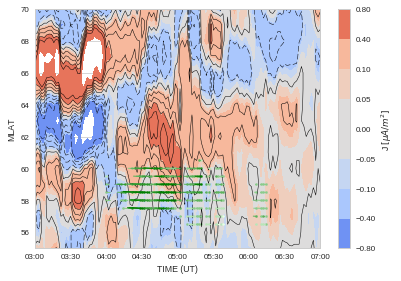

In [22]:
# Some temp constants
plotMltChsn = 22
if plotMltChsn > 12 :
    plotNormMlstChsn = plotMltChsn - 24
else:
    plotNormMlstChsn = plotMltChsn
plotJrCutoff = 0.
plotJrMin = -0.4
plotJrMax = 0.4
ticks = [ -0.8, -0.4, -0.1, -0.05, 0, 0.05, 0.1, 0.4, 0.8 ]
colNorm = Normalize( vmin=velScale[0], vmax=velScale[1] )
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=30)
# Plotting
seaMap = ListedColormap(sns.color_palette("coolwarm",11))

sns.set_style("whitegrid")
sns.set_context("paper")

fig = plt.figure()
ax = fig.add_subplot(111)
selDF = ampDF[ ((ampDF["start_date"] >= timeStart) & (ampDF["start_date"] <= timeEnd) &\
                    (ampDF["mlt"] == plotMltChsn) & (numpy.abs(ampDF["Jr"])>=plotJrCutoff) &\
              (ampDF["mlat"] >= plotMlatRange[0]) & (ampDF["mlat"] <= plotMlatRange[1]) )]
selDF["time"] = [ date2num(x) for x in selDF["start_date"] ]
plotAmpDF = selDF[ ["mlat", "time",\
                        "Jr"] ].pivot( "mlat", "time" )
mlatVals = plotAmpDF.index.values
timeVals = plotAmpDF.columns.levels[1].values
mlatCntr, timeCntr  = numpy.meshgrid( mlatVals, timeVals )
jrVals = numpy.ma.masked_where(numpy.isnan(plotAmpDF["Jr"].values),plotAmpDF["Jr"].values)
ampPlot = ax.contourf(timeCntr, mlatCntr,jrVals.T, ticks,cmap=seaMap)
ax.contour(timeCntr, mlatCntr,jrVals.T, numpy.linspace(-0.5, 0.5, 9),
                 origin='lower',
                 linewidths=0.5,colors='k')
cbar = plt.colorbar(ampPlot)
cbar.set_label(r"J $ [\mu A/m^{2}]$")

ax.set_xticks(xTickList)

ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

# Plot SD data
velColors = [ "#feebe2", "#fbb4b9", "#f768a1", "#c51b8a", "#7a0177" ]
# ax.scatter( fitsDF["date"].values, fitsDF["medLat"].values,\
#            c=fitsDF["velSAPS"].values, s=fitsDF["velSAPS"].values/3.,\
#           cmap=ListedColormap(sns.light_palette("Purple")), alpha=0.75)

ax.set_xlim( [timeStart, timeEnd] )
ax.set_ylim( plotMlatRange )
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
ax.set_xticks(xTickList)

ax.set_xlabel("TIME (UT)")
ax.set_ylabel("MLAT")
seaMap = ListedColormap( sns.light_palette("green") )
# ax2 = ax.twiny()

fitsDF = lshellDF[ lshellDF["normMlt"] == plotNormMlstChsn ]
for index, row in fitsDF.iterrows():
    currCol = seaMap( colNorm(row['velSAPS']) )
#     print row["mlat"], row["endPtMLAT"]
    ax.plot( [ row["time"], row["endPtTime"]], [ row["mlat"],\
                row['endPtMLAT'] ], color=currCol, linewidth=1.0 )
    ax.scatter( row["time"], row["mlat"], c=currCol, s=5.0 )        
#     ax.arrow( row["time"], row["mlat"], row["endPtTime"]-row["time"],\
#               row['endPtMLAT']-row["mlat"],\
#              head_width=0.05, head_length=0.01, fc=currCol, ec=currCol)



# ax2.set_ylim( plotMlatRange )



# for index, row in fitsDF.iterrows():
#     currCol = seaMap( colNorm(row['velSAPS']) )
#     if row['velSAPS'] < saisVelCutoff:
#         currCol = "#636363"
#     # Min Lat Loc
#     ax2.plot( [ row["time"], row["endPtTime"]], [ row["minLat"],\
#                 row['endPtMinMLAT'] ], color=currCol, linewidth=3.0 )        
#     ax2.arrow( row["time"], row["minLat"], row["endPtTime"]-row["time"], row['endPtMinMLAT']-row["minLat"],\
#              head_width=0.6, head_length=0.1, fc=currCol, ec=currCol)
#     # Median Lat Loc
#     ax2.plot( [ row["time"], row["endPtTime"]], [ row["medLat"],\
#                 row['endPtMedMLAT'] ], color=currCol, linewidth=3.0 )        
#     ax2.arrow( row["time"], row["medLat"], row["endPtTime"]-row["time"], row['endPtMedMLAT']-row["medLat"],\
#              head_width=0.6, head_length=0.1, fc=currCol, ec=currCol)
#     # Max Lat loc
#     ax2.plot( [ row["time"], row["endPtTime"]], [ row["maxLat"],\
#                 row['endPtMaxMLAT'] ], color=currCol, linewidth=3.0 )        
#     ax2.arrow( row["time"], row["maxLat"], row["endPtTime"]-row["time"], row['endPtMaxMLAT']-row["maxLat"],\
#              head_width=0.6, head_length=0.1, fc=currCol, ec=currCol)
# # Need to carefully set the x-axis
# ax2.set_xlim([(timeStart.hour + timeStart.minute/60.)*arrowLenFactor,\
#               (timeEnd.hour + timeEnd.minute/60.)*arrowLenFactor])
# ax2.axis('off')

fig.savefig( "../plots/saps-loc-amp.pdf",bbox_inches='tight' )